In [1]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [2]:
# SP_500 = yf.download('^GSPC' , start = '1986-03-13' , end = '2023-05-18', interval = '1d')

In [3]:
# SP_500.to_csv(r'O:\Second Semister\Artificial intelligence and ML in finance services\course_work\cw2\SP_500.csv')

In [4]:
df = pd.read_csv(r'O:\Second Semister\Artificial intelligence and ML in finance services\course_work\cw2\AAPL.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600
...,...,...,...,...,...,...,...
10693,2023-05-12,173.619995,174.059998,171.000000,172.570007,172.570007,45497800
10694,2023-05-15,173.160004,173.210007,171.470001,172.070007,172.070007,37266700
10695,2023-05-16,171.990005,173.139999,171.800003,172.070007,172.070007,42110300
10696,2023-05-17,171.710007,172.929993,170.419998,172.690002,172.690002,57951600


In [5]:
# Selecting two columns 
df = df[['Date', 'Close']]

In [6]:
df['Date']

0        1980-12-12
1        1980-12-15
2        1980-12-16
3        1980-12-17
4        1980-12-18
            ...    
10693    2023-05-12
10694    2023-05-15
10695    2023-05-16
10696    2023-05-17
10697    2023-05-18
Name: Date, Length: 10698, dtype: object

In [7]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)


In [8]:
df['Date'] = df['Date'].apply(str_to_datetime)

C:\Users\mahmoud\AppData\Local\Temp\ipykernel_268\3172778012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


In [9]:
df.index = df.pop('Date')
df

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862
...,...
2023-05-12,172.570007
2023-05-15,172.070007
2023-05-16,172.070007


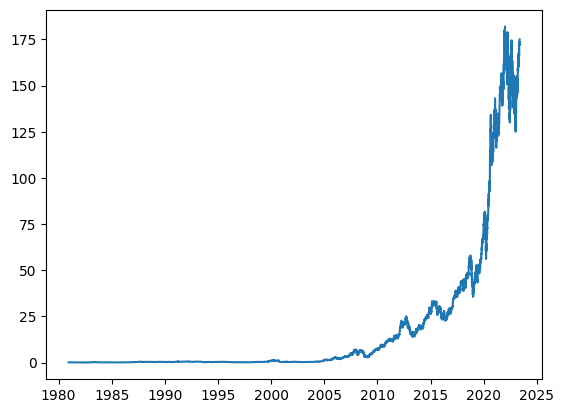

In [10]:
plt.plot(df.index, df['Close'])

In [11]:
# Converting to a supervised problem 

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-05-18', 
                                '2023-05-17', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-05-18,124.970001,127.449997,126.269997,124.849998
1,2021-05-19,127.449997,126.269997,124.849998,124.690002
2,2021-05-20,126.269997,124.849998,124.690002,127.309998
3,2021-05-21,124.849998,124.690002,127.309998,125.430000
4,2021-05-24,124.690002,127.309998,125.430000,127.099998
...,...,...,...,...,...
499,2023-05-11,173.500000,171.770004,173.559998,173.750000
500,2023-05-12,171.770004,173.559998,173.750000,172.570007
501,2023-05-15,173.559998,173.750000,172.570007,172.070007
502,2023-05-16,173.750000,172.570007,172.070007,172.070007


In [12]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((504,), (504, 3, 1), (504,))

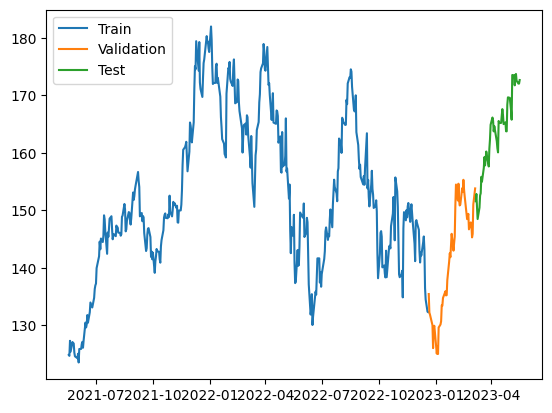

In [13]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test']);

In [14]:
# building modele and training 
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 [==============================] - 4s 58ms/step - loss: 23333.7148 - mean_absolute_error: 152.1541 - val_loss: 19935.8730 - val_mean_absolute_error: 140.8769
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 23003.1777 - mean_absolute_error: 151.0660 - val_loss: 19621.8848 - val_mean_absolute_error: 139.7578
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 22575.9648 - mean_absolute_error: 149.6457 - val_loss: 19110.5566 - val_mean_absolute_error: 137.9160
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 21877.5781 - mean_absolute_error: 147.2883 - val_loss: 18196.3379 - val_mean_absolute_error: 134.5603
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 20651.7129 - mean_absolute_error: 143.0555 - val_loss: 16809.1445 - val_mean_absolute_error: 129.3012
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 18856.0859 - mean_absolute_error: 136.6080 - val_lo

Epoch 50/100
13/13 [==============================] - 0s 7ms/step - loss: 9.8832 - mean_absolute_error: 2.4042 - val_loss: 7.6131 - val_mean_absolute_error: 2.1865
Epoch 51/100
13/13 [==============================] - 0s 7ms/step - loss: 9.8280 - mean_absolute_error: 2.4332 - val_loss: 7.2087 - val_mean_absolute_error: 2.1584
Epoch 52/100
13/13 [==============================] - 0s 7ms/step - loss: 9.6134 - mean_absolute_error: 2.3841 - val_loss: 8.7961 - val_mean_absolute_error: 2.3904
Epoch 53/100
13/13 [==============================] - 0s 7ms/step - loss: 11.9245 - mean_absolute_error: 2.7044 - val_loss: 9.6417 - val_mean_absolute_error: 2.5175
Epoch 54/100
13/13 [==============================] - 0s 7ms/step - loss: 10.4927 - mean_absolute_error: 2.4980 - val_loss: 6.3063 - val_mean_absolute_error: 2.0131
Epoch 55/100
13/13 [==============================] - 0s 7ms/step - loss: 9.6979 - mean_absolute_error: 2.3759 - val_loss: 6.3331 - val_mean_absolute_error: 2.0494
Epoch 56/100
1

Epoch 100/100
13/13 [==============================] - 0s 7ms/step - loss: 9.6782 - mean_absolute_error: 2.3773 - val_loss: 7.0817 - val_mean_absolute_error: 2.1435


13/13 [==============================] - 1s 2ms/step


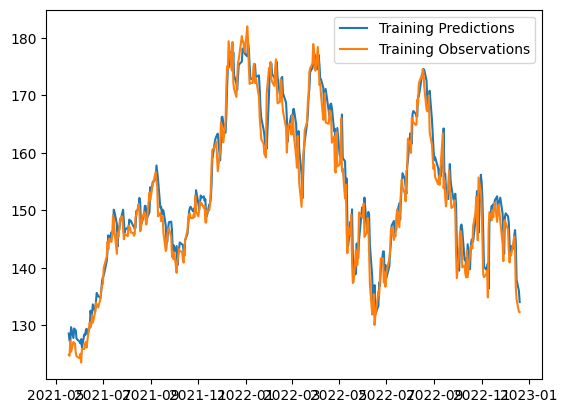

In [15]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations']);

2/2 [==============================] - 0s 4ms/step


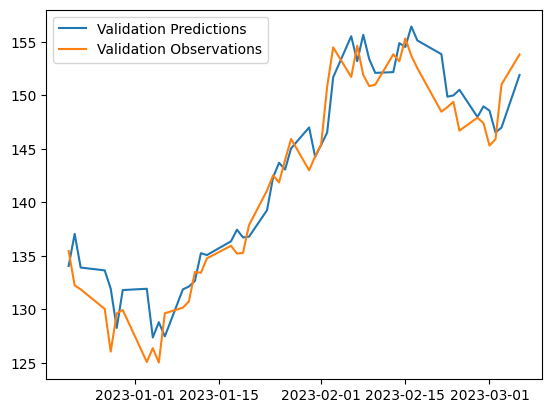

In [16]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 3ms/step


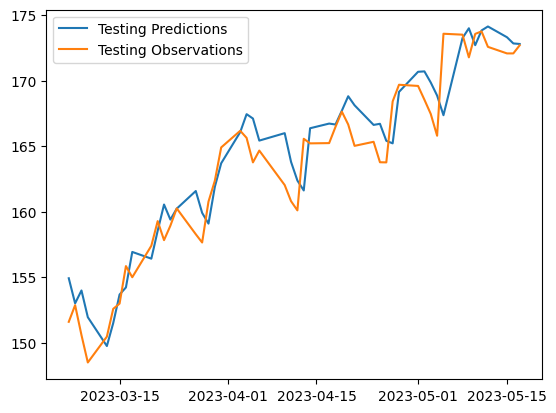

In [17]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

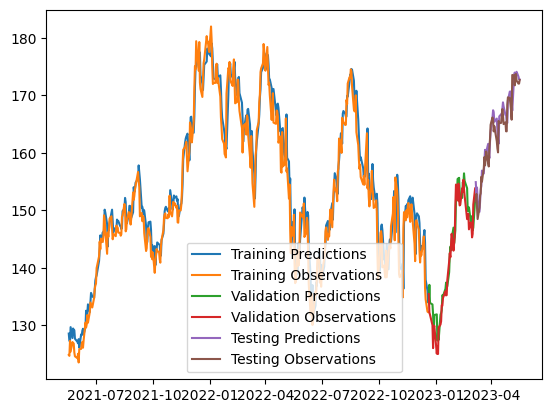

In [18]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations']);

In [19]:

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 38ms/step


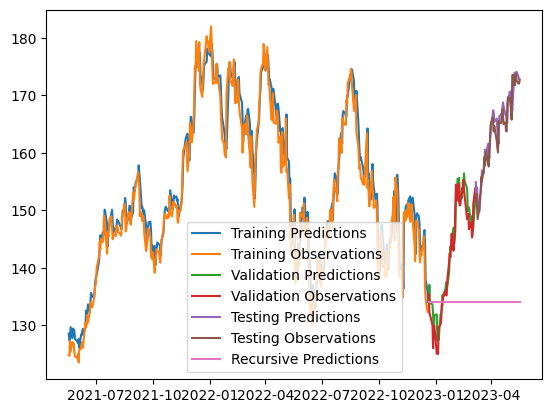

In [20]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])